In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sc.settings.verbosity = 3 # verbosity 的取值表示测试结果显示的详细程度，数字越大越详细
# sc.logging.print_versions() # 输出版本号
sc.settings.set_figure_params(dpi=80) # set_figure_params 设置图片的分辨率/大小以及其他样式
import os #在服务器运行，习惯性会设置一个输出路径，用于保存pdf图片
print(os.getcwd())  #查看当前路径
os.chdir('D:/bio/jupyter_code/data/pbmc3k_filtered_gene_bc_matrices') #修改路径
print(os.getcwd())
results_file = 'pbmc3k.h5ad' ##置结果文件保存路径

D:\bio\jupyter_code
D:\bio\jupyter_code\data\pbmc3k_filtered_gene_bc_matrices


In [2]:
# 导入 10X 数据
data=sc.read_10x_mtx('./filtered_gene_bc_matrices/hg19/',var_names='gene_symbols',   cache=True)
data.var_names_make_unique()  # 索引去重，若上一步中使用 `var_names='gene_ids'` 则这一步非必须进行
#data.X 存储 count matrix，数据类型为稀疏矩阵 scipy.sparse.csr.csr_matrix
#data.obs 存储关于 obervations(cells) 的 metadata，数据类型为 dataframe
#data.var 存储关于 variables(genes) 的 metadata，数据类型为 dataframe
#AnnData.uns 存储后续附加的其他非结构化信息
#data.obs_names 和 adata.var_names index
#细胞名和基因名可分别通过 adata.obs_names 和 adata.var_names 查看。 AnnData 对象可以像 dataframe 一样进行切片操作，例如，data_subset = data[:, list_of_gene_names]

print(data)
print(data.X)
print(data.obs)
print(data.var)
print(data.uns)
print(data.obs_names)
print(data.var_names)

# 当然scanpy可以直接读取10Xgenomics的.h5格式数据
# data=sc.read_10x_h5("./pbmc3K.h5",genome=None,gex_only=True)
# adata.var_names_make_unique()`

... reading from cache file cache\filtered_gene_bc_matrices-hg19-matrix.h5ad
AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'
  (0, 70)	1.0
  (0, 166)	1.0
  (0, 178)	2.0
  (0, 326)	1.0
  (0, 363)	1.0
  (0, 410)	1.0
  (0, 412)	1.0
  (0, 492)	41.0
  (0, 494)	1.0
  (0, 495)	1.0
  (0, 496)	1.0
  (0, 525)	1.0
  (0, 556)	2.0
  (0, 558)	6.0
  (0, 671)	1.0
  (0, 684)	1.0
  (0, 735)	1.0
  (0, 770)	1.0
  (0, 793)	1.0
  (0, 820)	1.0
  (0, 859)	2.0
  (0, 871)	1.0
  (0, 908)	15.0
  (0, 926)	1.0
  (0, 941)	1.0
  :	:
  (2699, 31849)	1.0
  (2699, 31855)	1.0
  (2699, 31887)	1.0
  (2699, 31949)	2.0
  (2699, 31970)	2.0
  (2699, 32022)	17.0
  (2699, 32044)	1.0
  (2699, 32047)	2.0
  (2699, 32059)	1.0
  (2699, 32065)	1.0
  (2699, 32066)	1.0
  (2699, 32082)	1.0
  (2699, 32186)	1.0
  (2699, 32193)	1.0
  (2699, 32322)	1.0
  (2699, 32442)	1.0
  (2699, 32543)	1.0
  (2699, 32581)	1.0
  (2699, 32641)	1.0
  (2699, 32696)	3.0
  (2699, 32697)	1.0
  (2699, 32698)	7.0
  (2699, 32702)	1.0
  (2699, 3

normalizing counts per cell
    finished (0:00:00)


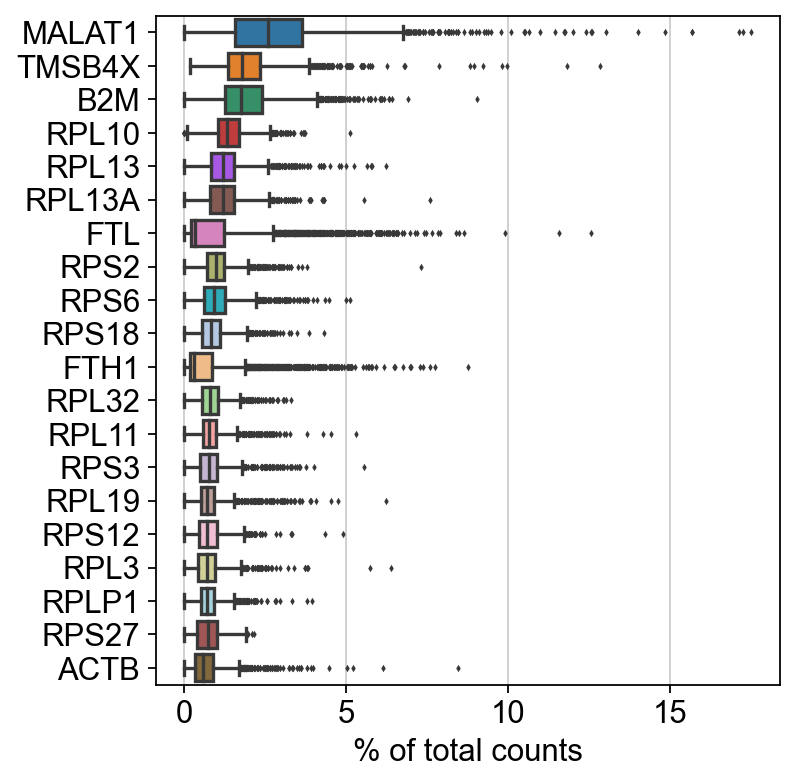

filtered out 19024 genes that are detected in less than 3 cells


<Figure size 320x320 with 0 Axes>

In [3]:
# 数据预处理（基因细胞过滤）：
sc.pl.highest_expr_genes(data, n_top=20)
plt.savefig("Highest_expr_genes.pdf")
#基础过滤：去除表达基因200以下的细胞；去除在3个细胞以下表达的基因。
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

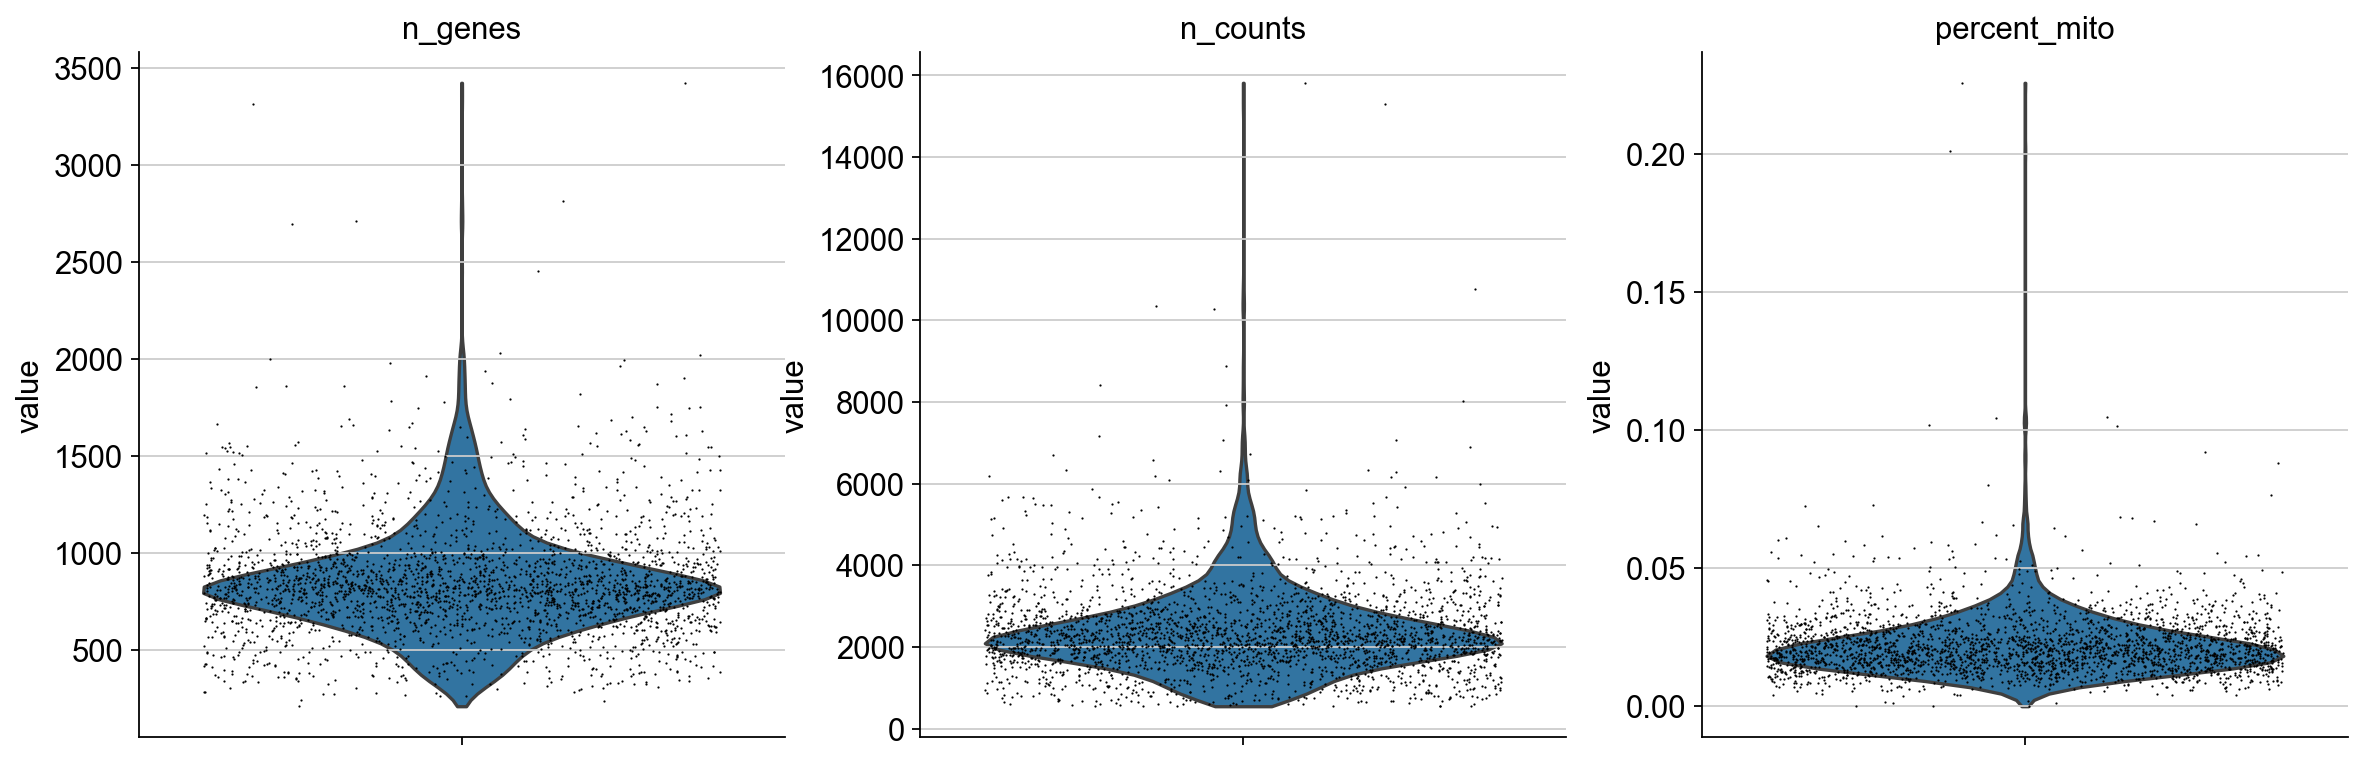

<Figure size 320x320 with 0 Axes>

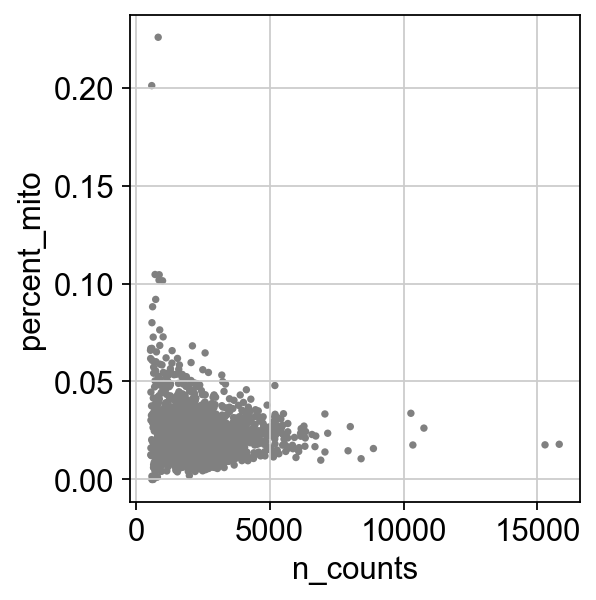

<Figure size 320x320 with 0 Axes>

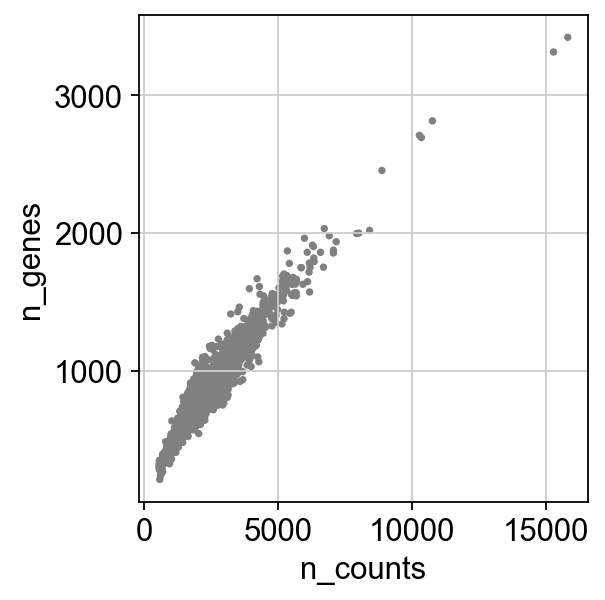

<Figure size 320x320 with 0 Axes>

In [4]:
#计算线粒体基因占所有基因的比例
mito_genes=data.var_names.str.startswith('MT-')
data.obs['percent_mito']=np.sum(data[:,mito_genes].X,axis=1).A1/np.sum(data.X,axis=1).A1
data.obs['n_counts']=data.X.sum(axis=1).A1
sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)
plt.savefig("QC_violin.pdf")
sc.pl.scatter(data, x='n_counts', y='percent_mito')
plt.savefig("QC_dot.pdf")
sc.pl.scatter(data,x='n_counts',y='n_genes')
plt.savefig("QC_dot1.pdf")
##过滤线粒体基因比例 > 5% 和基因总数 >2500 的细胞。
data = data[data.obs.n_genes < 2500, :]
data = data[data.obs.percent_mito < 0.05, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


D:\anaconda\envs\stagate\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


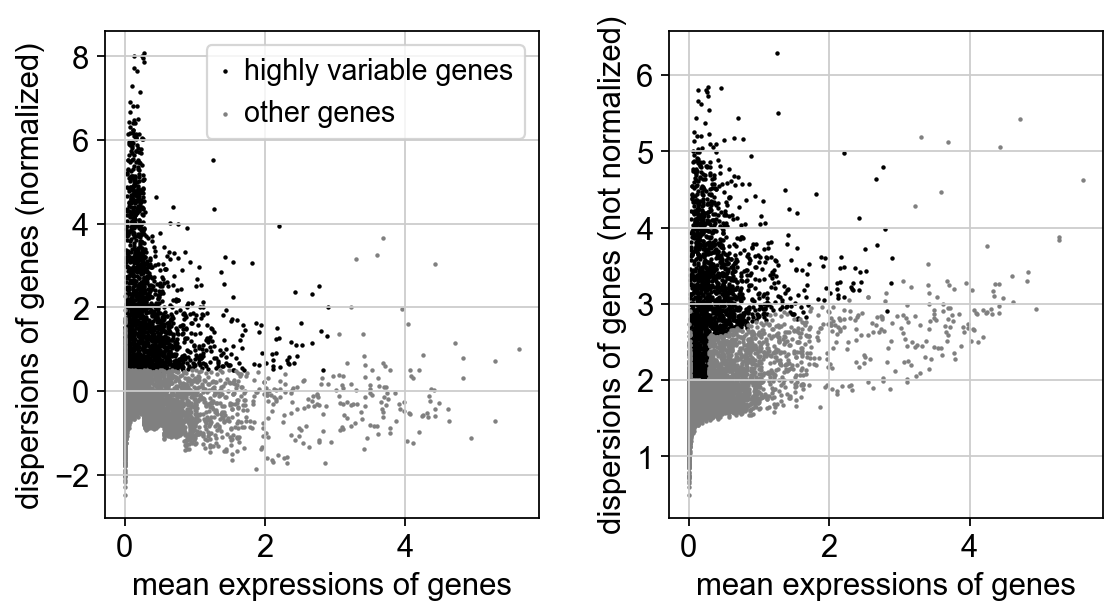

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:05)


<Figure size 320x320 with 0 Axes>

In [5]:
# 数据预处理（标准化，挑选HVG基因）
sc.pp.normalize_total(data, target_sum=1e4) ##标准化
sc.pp.log1p(data)
data.raw = data
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(data)
plt.savefig("highly_variable_genes.pdf")
data = data[:, data.var.highly_variable] 
sc.pp.regress_out(data, ['n_counts', 'percent_mito']) #校正细胞基因计数和线粒体基因比例的影响。
sc.pp.scale(data, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


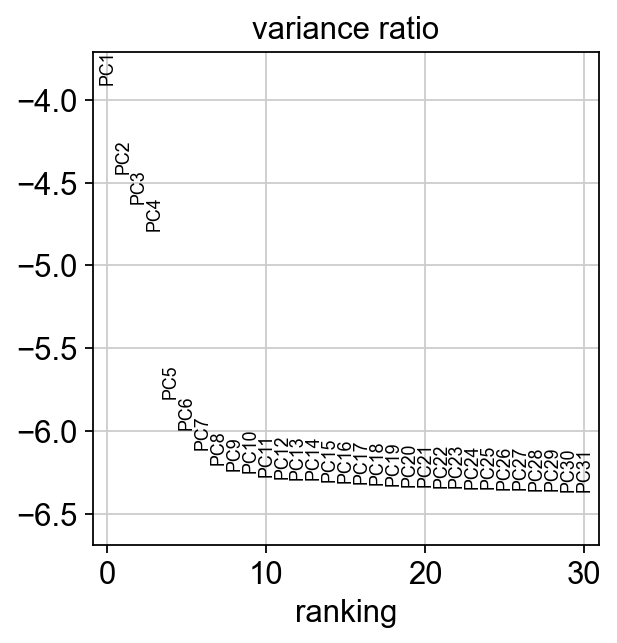

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


<Figure size 320x320 with 0 Axes>

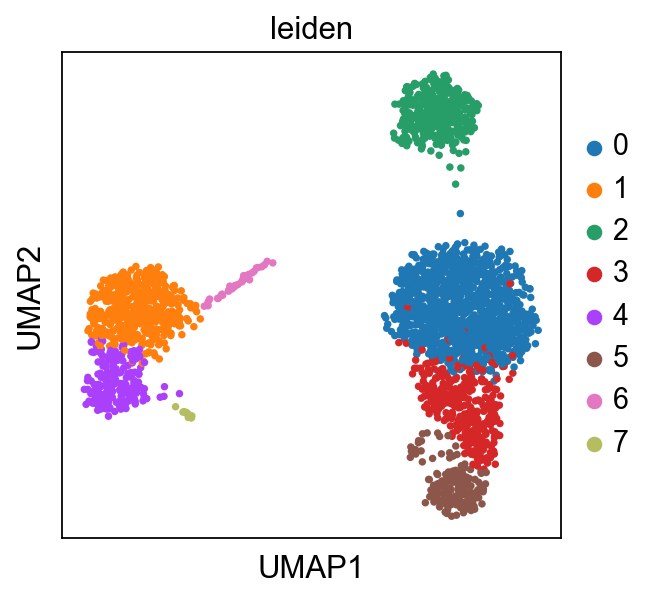

<Figure size 320x320 with 0 Axes>

In [6]:
# PCA降维，聚类，Umap可视化
sc.tl.pca(data, svd_solver='arpack')# svd_solver 指定奇异值分解 SVD 的方法
sc.pl.pca_variance_ratio(data, log=True)
plt.savefig("PCA.pdf")
data.write(results_file)
sc.pp.neighbors(data, n_neighbors=10, n_pcs=40)
sc.tl.leiden(data) #使用leiden进行聚类，注意安装对应的python包，conda install -c conda-forge leidenalg ，当然也可使用其他的聚类算法，如louvain，sc.tl.louvain(data),sc.pl.umap(adata, color=['louvain'])，比较了一下，聚类结果差异不大
sc.tl.umap(data)
sc.pl.umap(data, color=['leiden'])
plt.savefig("Umap.pdf")
data.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


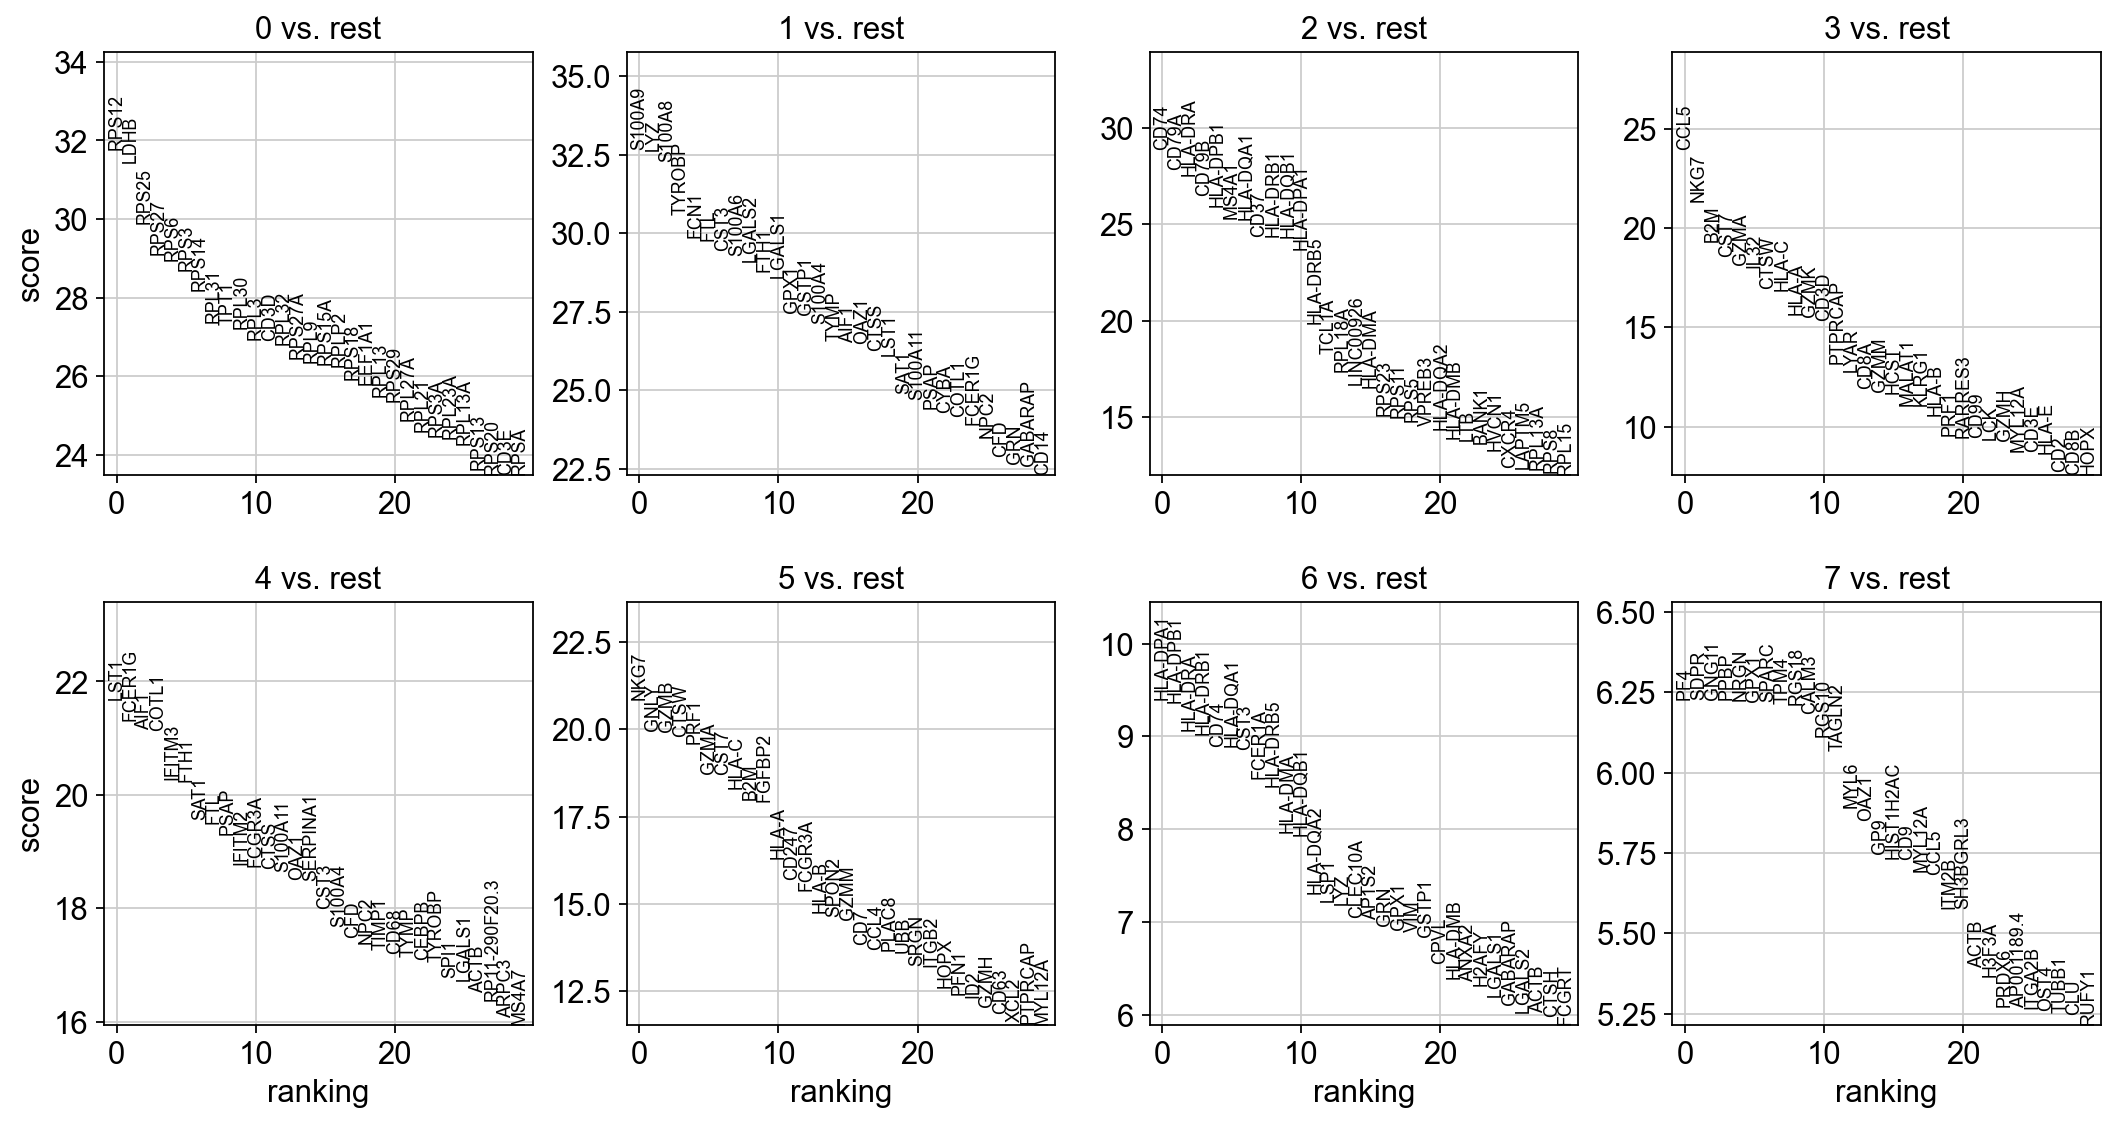

<Figure size 320x320 with 0 Axes>

In [7]:
# 预测簇 marker genes
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=30, sharey=False)
plt.savefig("dif_gene.pdf")
data.write(results_file)

data = sc.read(results_file)
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(5)
data.uns['rank_genes_groups'].keys()
#dict_keys(['logfoldchanges', 'names', 'params', 'pvals', 'pvals_adj', 'scores'])
result = data.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(    {group + '_' + key[:1]: result[key][group]    for group in groups for key in ['names', 'pvals']}).head(5)
res = pd.DataFrame(    {group + '_' + key: result[key][group]    for group in groups for key in ['names', 'pvals','logfoldchanges','pvals_adj','scores']})
res.to_csv("dif.csv") #基因差异情况输出到本地保存

In [8]:
# 当然任意两个簇之间也可以比较差异:
sc.tl.rank_genes_groups(data, 'leiden', groups=['0'], reference='1', method='wilcoxon') #cluster0 与 cluster1之间进行比较
sc.pl.rank_genes_groups(data, groups=['0'], n_genes=20)
plt.savefig("gene_exp_C0_C1_score.pdf")
sc.pl.rank_genes_groups_violin(data, groups='0', n_genes=8)
plt.savefig("gene_exp_C0_C1_vio.pdf")
data = sc.read(results_file)
sc.pl.rank_genes_groups_violin(data, groups='0', n_genes=8)
plt.savefig("gene_exp_C0_all_vio.pdf")

ranking genes


KeyError: 'base'

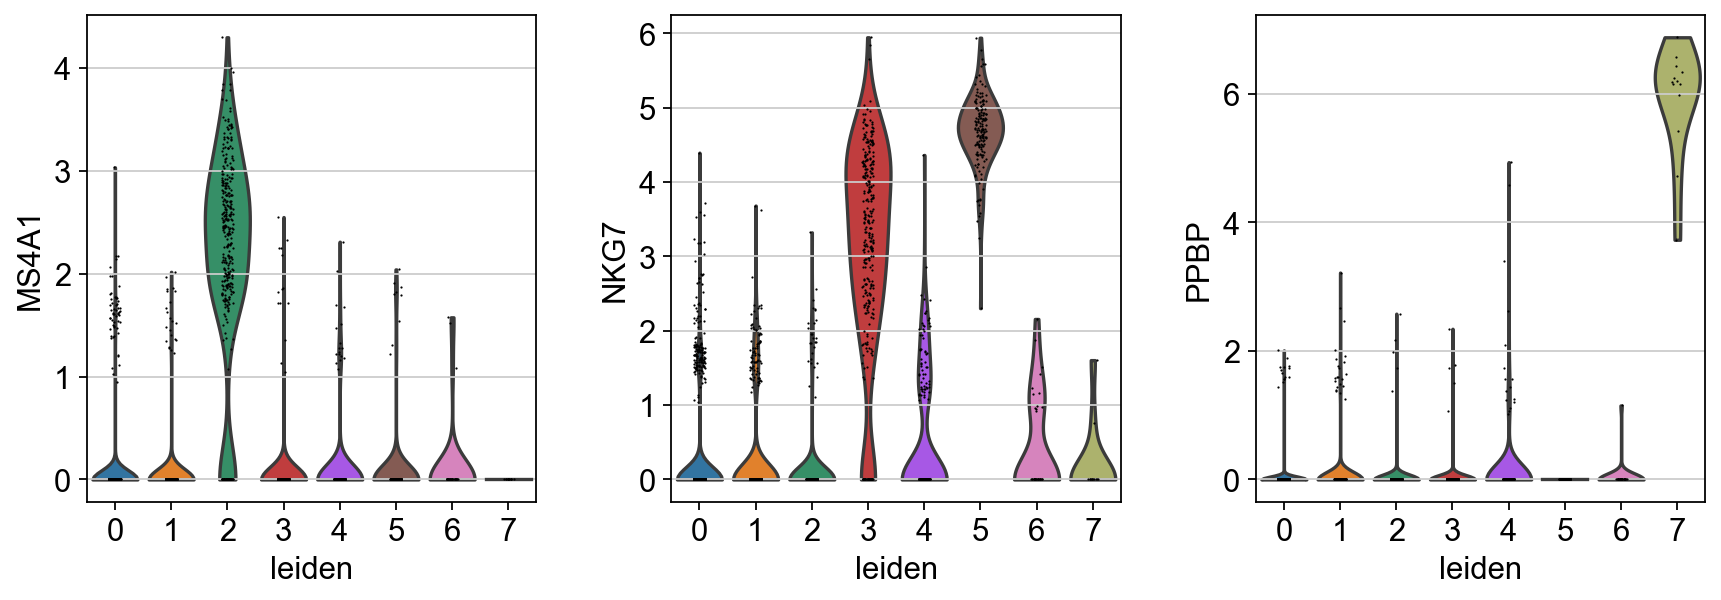

<Figure size 320x320 with 0 Axes>

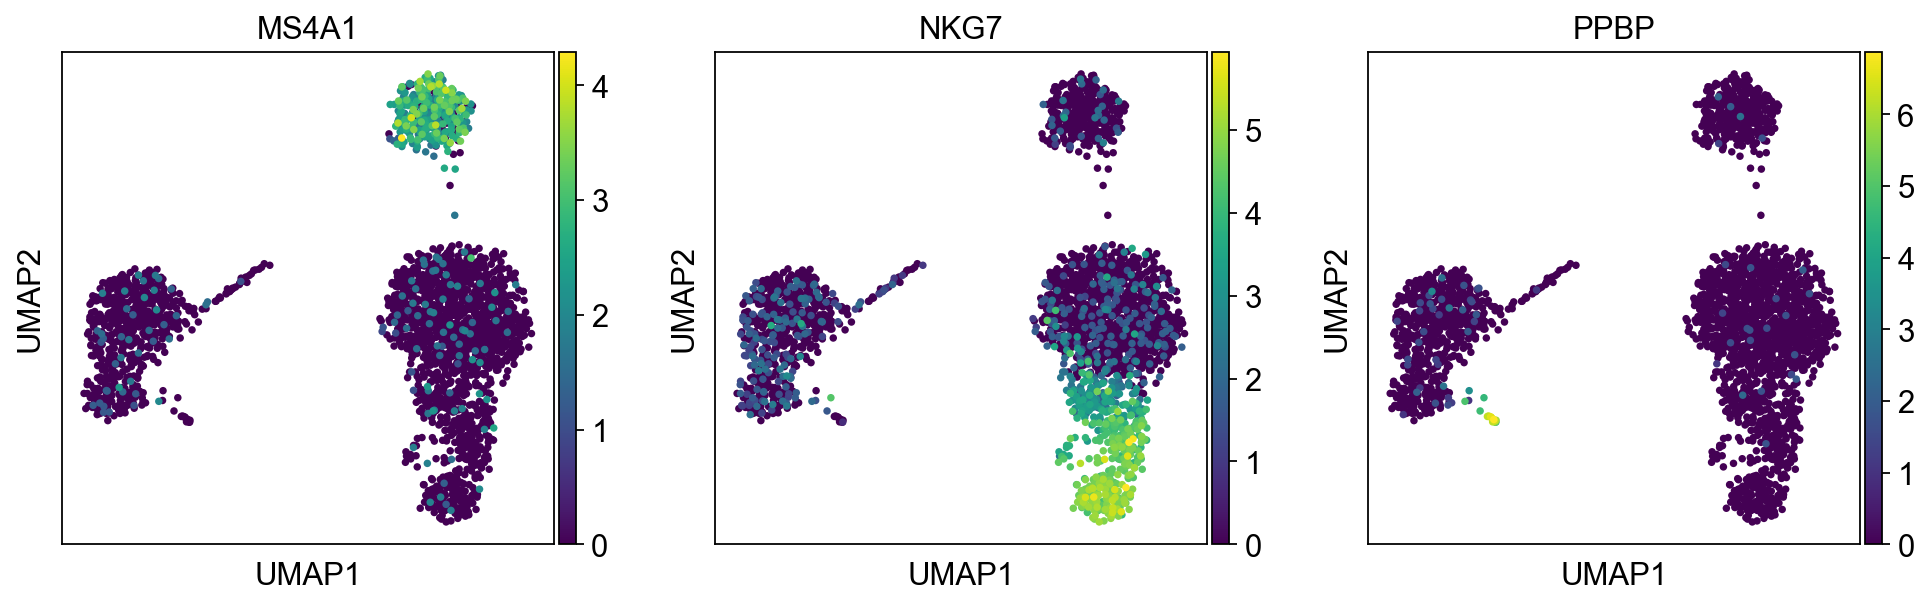

<Figure size 320x320 with 0 Axes>

In [9]:
# 任意基因表达可视化(小提琴图、umap)
sc.pl.violin(data, ['MS4A1', 'NKG7', 'PPBP'], groupby='leiden')
plt.savefig("marker_exp_Vio.pdf")
sc.pl.umap(data, color=['MS4A1', 'NKG7', 'PPBP'])
plt.savefig("marker_exp_umap.pdf")

D:\anaconda\envs\stagate\lib\site-packages\pandas\core\arrays\categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


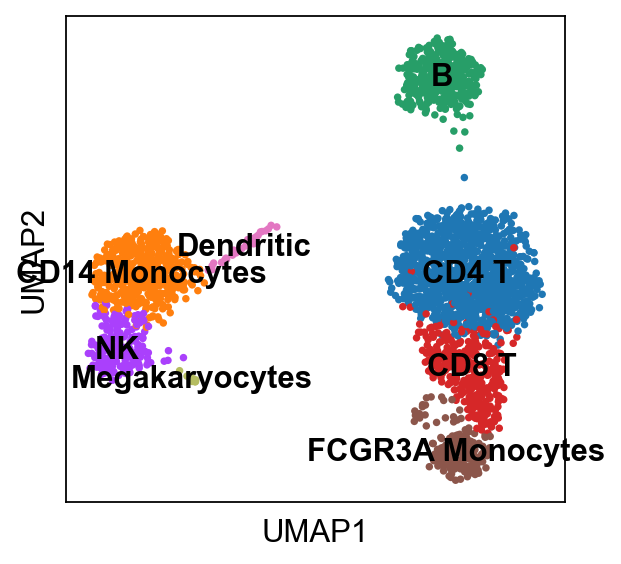

<Figure size 320x320 with 0 Axes>

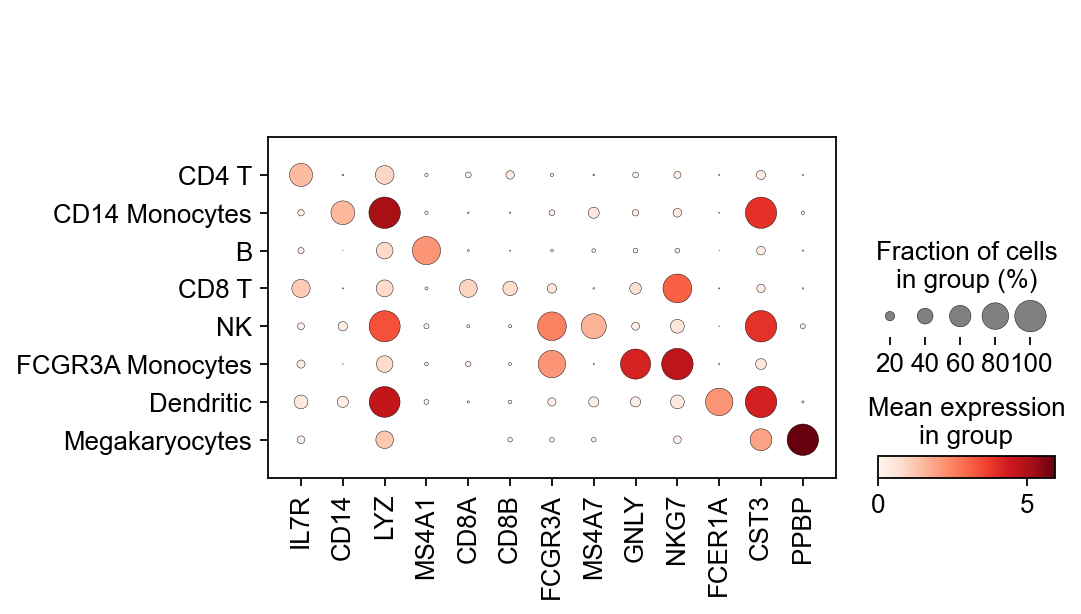

<Figure size 320x320 with 0 Axes>

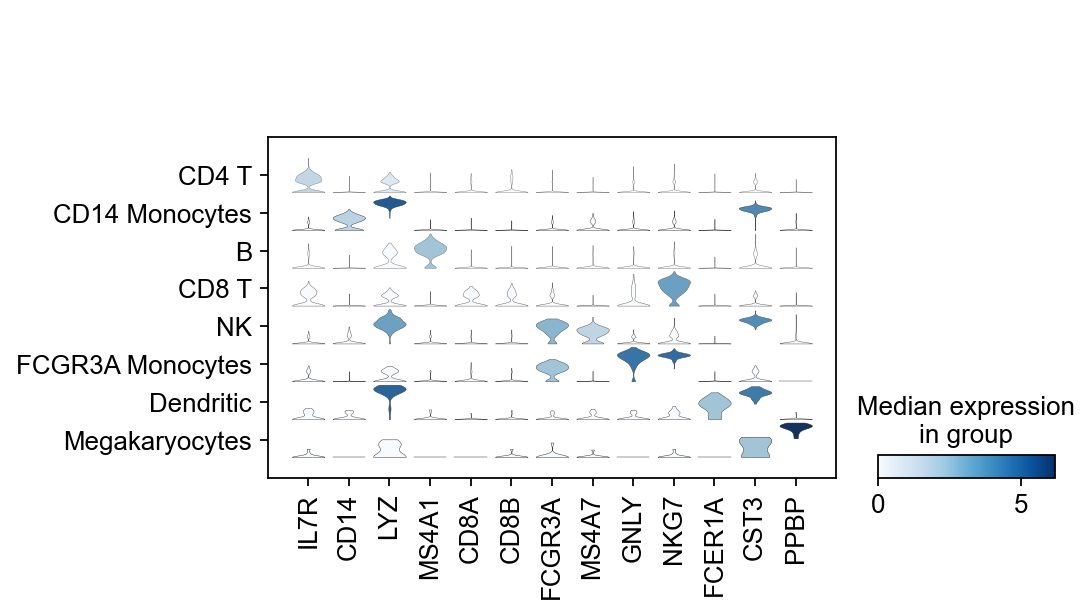

<Figure size 320x320 with 0 Axes>

In [10]:
# 确定细胞类别，打上细胞类别标签，绘制已知marker gene的小提琴图
marker_genes = ['IL7R', 'CD14', 'LYZ',  'MS4A1', 'CD8A', 'CD8B', 'FCGR3A', 'MS4A7','GNLY', 'NKG7', 'FCER1A', 'CST3', 'PPBP']
new_cluster_names = ['CD4 T', 'CD14 Monocytes','B', 'CD8 T','NK', 'FCGR3A Monocytes','Dendritic', 'Megakaryocytes']
data.rename_categories('leiden', new_cluster_names)
sc.pl.umap(data, color='leiden', legend_loc='on data', title='', frameon=True)
plt.savefig("umap_celltype.pdf")
ax = sc.pl.dotplot(data, marker_genes, groupby='leiden')
plt.savefig("gene_Dot_celltype.pdf")
ax = sc.pl.stacked_violin(data, marker_genes, groupby='leiden', rotation=90)
plt.savefig("gene_Vio_celltype.pdf")